In [ ]:
!nvidia-smi

Sun Sep 27 13:57:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
! pip install '/content/gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl'
from TaPR_pkg import etapr

Processing ./gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl


In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import random
import sys
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
path = '/content/gdrive/My Drive/Dacon/HAI 2.0/'

path_train = path + 'training'
path_valid = path + 'validation'
path_test = path + 'testing'
path_submission = path + 'sample_submission.csv'

'''seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)'''

# these change models
timelen = 100
stride = 2

# these can be changed any time 
# no validation. only check if TaPR goes up.
epoch = 50
batch_size = 64
verbose = 2
optim = 'adam' # tfa.optimizers.SWA(tf.keras.optimizers.SGD())

In [ ]:
########################################################################################### basic functions
def plot_history(history):
    plt.rcParams['figure.figsize'] = [16, 4]
    plt.plot(history.history['loss'], 'r--', history.history['val_loss'], 'b--')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def get_progressbar_str(progress):
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))
    
def put_labels(submission, threshold):
    temp = np.zeros_like(submission, dtype = 'int8')
    temp[submission > threshold] = 1
    return temp

def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(25, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak )
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

def test_and_get_list(model, some_list, some_raw_list):
    loss_list = []
    for num, (timeseq, raw) in enumerate(zip(some_list, some_raw_list)):
        res = np.zeros(timelen, dtype = 'float32')  # padding
        timeseq_X = Test_DataLoader(timeseq)
        with tf.device('/device:GPU:0'):
            predicted = model.predict(timeseq_X)
        pr = np.mean( np.abs(predicted - raw[timelen:]), axis = 1).astype('float32')
        pr[:-timelen] /= 2       # 뒤에 timelen 개 빼고는 2로 나눠준다. (back + forth 할 것이기 때문. 겹치는 것만 2로 나눔.)
        res = np.concatenate((res, pr), axis=0)
        assert len(res) == len(raw)
        # loss = np.mean(np.abs(res, raw), axis = 1)
        loss_list.append(res)
    for num, loss in enumerate(loss_list):
        if num == 0:
            res = loss
        else:
            res = np.concatenate((res,loss), axis = 0)
    return res

def find_best_th(start, end, valid_result, valid_label, NN = 100):
    res = []
    ff = start
    ee = end
    inc = 0
    print('checking for TaPR...')
    for i in range(NN):
        th = ff + i * (ee-ff)/NN
        final = put_labels(valid_result, th)
        TaPR = etapr.evaluate(anomalies=valid_label, predictions=final)
        res.append((TaPR['f1'],th))
        inc += 1
        sys.stderr.write('\r\033[K' + get_progressbar_str(inc/NN))
        sys.stderr.flush()
    score, threshold = max(res)
    return score, threshold

In [ ]:
########################################################################################### data preparation basic functions
class Test_DataLoader(keras.utils.Sequence):  # timegen 하나가 X 값만 뽑아줄 수 있도록 한다.
    def __init__(self,test_seq):
        self.test_seq = test_seq
    def __getitem__(self, i):
        return self.test_seq[i][0]
    def __len__(self):
        return len(self.test_seq)

def read_data(path, att = False, scaler = None, C_cols = None, demand_validation_ratio = None):
    file_paths = glob.glob(path+'/*.csv')
    res,res_inverse = [], []
    print("="*30)
    print("Attack :",att)
    if att and scaler and C_cols:
        label = None
        temp = 0
        for file in file_paths:
            f = pd.read_csv(file)
            temp += len(f)
            if 'attack' in f.columns:
                label = f['attack']
            target = scaler.transform(f[C_cols].values)
            res.append(target)
            res_inverse.append(np.flip(target))
        print("Total test data : ", temp)
        print("List of DataFrame length : ",len(res))
        return res, res_inverse[::-1], label
    else:
        # df : appended dataframe to fit scaler
        df = pd.DataFrame()
        for file in file_paths:
            f=pd.read_csv(file)
            df = df.append(f, ignore_index=True)
            res.append(f)
        print("Total data length (including non-usable datas) : ",len(df))
        # make C01 ~ C79 list
        C_cols = list(df.columns)
        C_cols.remove('time')
        # make scaler
        scaler = MinMaxScaler()
        scaler.fit(df[C_cols].values)
        temp = 0
        for i, item in enumerate(res):
            target = scaler.transform(item[C_cols].values)
            res[i] = target
            res_inverse.append(np.flip(target))
            temp += len(res[i])
        print("List of DataFrame length : ",len(res))
        return res, res_inverse[::-1], C_cols, scaler

train_list, train_list_inverse, C_cols, scaler = read_data(path_train)
valid_list, valid_list_inverse, valid_label = read_data(path_valid, att=True, scaler = scaler, C_cols = C_cols)
test_list, test_list_inverse, _ = read_data(path_test, att=True, scaler = scaler, C_cols = C_cols)
print(train_list[0].shape, train_list_inverse[-1].shape, valid_list[0].shape, valid_list_inverse[-1].shape, valid_label.shape, test_list[0].shape, test_list_inverse[-1].shape)

def seq2timeser(some_list,sr,st,le,ba,sh):
    res = []
    for item in some_list:
        res.append( TimeseriesGenerator(item, item, sampling_rate = sr, stride = st, length = le, batch_size=ba, shuffle = sh) )
    return res

train_list_seq = seq2timeser(train_list, 1, stride, timelen, batch_size, True)
train_list_inverse_seq = seq2timeser(train_list, 1, stride, timelen, batch_size, True)

valid_list_seq = seq2timeser(valid_list, 1, 1, timelen, 1000, False)
valid_list_inverse_seq = seq2timeser(valid_list, 1, 1, timelen, 1000, False)

test_list_seq = seq2timeser(test_list, 1, 1, timelen, 1000, False)
test_list_inverse_seq = seq2timeser(test_list, 1, 1, timelen, 1000, False)

Attack : False
Total data length (including non-usable datas) :  921603
List of DataFrame length :  3
Attack : True
Total test data :  43201
List of DataFrame length :  1
Attack : True
Total test data :  358804
List of DataFrame length :  4
(216001, 79) (216001, 79) (43201, 79) (43201, 79) (43201,) (118801, 79) (118801, 79)


In [ ]:
modelname = 'HAI_back&forward_1'

In [ ]:
def model(show = True):                                   # 3skip, 2layer, 3attention
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att2 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att2])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att3 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att3])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    if show:
        print(model.summary())
    return model

model_f = model()
model_b = model(show=False)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 79)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 200)     144000      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 100, 79), (N 176960      bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 100, 79)      6320        bidirectional_1[0][0]            
_______________________________________________________________________________________

Start Training...
epoch :  0


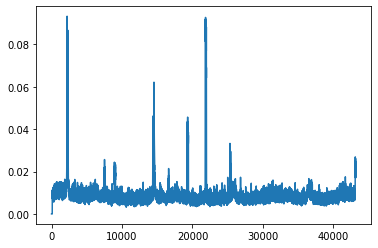

(43201,)


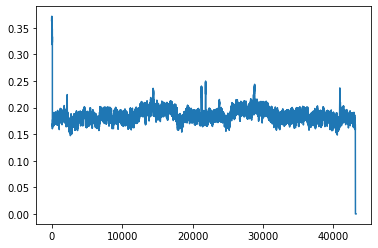

(43201,)


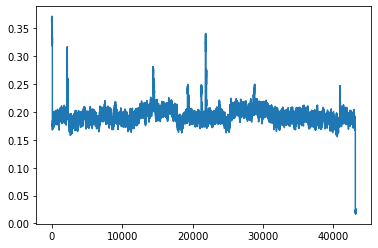

(43201,)
checking for TaPR...


Progress:[==>                            ] 9.0%

KeyboardInterrupt: ignored

In [ ]:
# data loader
class Train_DataLoader(keras.utils.Sequence):  # [timegen, timegen, ...] 으로 된 것을 랜덤하게 합쳐준다.
    def __init__(self,train_list):
        self.train_list = train_list
        idx = []
        for num, item in enumerate(train_list):
            idx = [(num, i) for i in range(len(item))]
        random.shuffle(idx)
        self.idx = idx

    def __getitem__(self, i):
        target_machine = self.idx[i][0]
        target_idx = self.idx[i][1]
        target = self.train_list[target_machine][target_idx]
        return target     # X, Y 형태로 나오고 있음.

    def __len__(self):
        return len(self.idx)

train_f = Train_DataLoader(train_list_seq)
train_b = Train_DataLoader(train_list_inverse_seq)

# training...
def generate_and_train_model(train_f, train_b, epoch, model_f, model_b, valid_list_seq, valid_list, valid_list_inverse_seq, valid_list_inverse): 
    print("Start Training...")
    for e in range(epoch):
        print('epoch : ',e)
        '''with tf.device('/device:GPU:0'):
            model_f.fit(train_f, epochs = 1, verbose = 2)
            model_b.fit(train_b, epochs = 1, verbose = 2)'''

        valid_result_f = test_and_get_list(model_f, valid_list_seq, valid_list)
        valid_result_b = test_and_get_list(model_b, valid_list_inverse_seq, valid_list_inverse)
        valid_result = valid_result_f + np.flip(valid_result_b)
        plt.plot(valid_result_f)
        plt.show()
        print(valid_result_f.shape)
        plt.plot(np.flip(valid_result_b))
        plt.show()
        print(np.flip(valid_result_b).shape)
        plt.plot(valid_result)
        plt.show()
        print(valid_result.shape)

        score, threshold = find_best_th(0, 0.1, valid_result, valid_label)
        if e > 30 and score < 0.93:
            print('This model has failed \n Skip to next model')
            break
        elif score < 0.95:
            print('  This epoch failed, score : ', score)
        else:
            print('I see hope in this model : ', modelname, '  epoch : ', e, '  score : ', score,'  TH_ : ',threshold) 
            model_f.save(path + modelname + 'f_epoch_' + str(e) + '.h5')
            model_b.save(path + modelname + 'b_epoch_' + str(e) + '.h5')
            print('model save : ', modelname + 'f_epoch_' + str(e) + '.h5 , ', modelname + 'b_epoch_' + str(e) + '.h5 ')
            test_result_f = test_and_get_list(model_f, test_list_seq, test_list)
            test_result_b = test_and_get_list(model_b, test_list_inverse_seq, test_list_inverse)
            test_result = test_result_f + np.flip(test_result_b)

            test_label = put_labels(test_result, threshold)
            check_graph(test_result, test_label, piece = 2, THRESHOLD= threshold)
            submission = pd.read_csv(path_submission)
            submission['attack'] = test_label
            submission.to_csv(path+'submission_'+str(modelname)+'bf_TH_'+str(threshold)+'_score_'+str(score)+'.csv',index = False)
            print('submission saved')


generate_and_train_model(train_f, train_b, epoch, model_f, model_b, valid_list_seq, valid_list, valid_list_inverse_seq, valid_list_inverse)

inverse쪽 성능이 너무 안좋다. 다른 방식을 고려해보자.

only forward
--------

In [ ]:
path = '/content/gdrive/My Drive/Dacon/HAI 2.0/'

path_train = path + 'training'
path_valid = path + 'validation'
path_test = path + 'testing'
path_submission = path + 'sample_submission.csv'

'''seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)'''

# these change models
timelen = 100
stride = 3

# these can be changed any time 
# no validation. only check if TaPR goes up.
epoch = 50
batch_size = 32
verbose = 1
optim = 'adam' # tfa.optimizers.SWA(tf.keras.optimizers.SGD())

In [ ]:
########################################################################################### basic functions
def plot_history(history):
    plt.rcParams['figure.figsize'] = [16, 4]
    plt.plot(history.history['loss'], 'r--', history.history['val_loss'], 'b--')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
def get_progressbar_str(progress):
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))
def put_labels(submission, threshold):
    temp = np.zeros_like(submission, dtype = 'int8')
    temp[submission > threshold] = 1
    return temp
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(25, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak )
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()
def test_and_get_list(model, some_list, some_raw_list):
    loss_list = []
    for num, (timeseq, raw) in enumerate(zip(some_list, some_raw_list)):
        res = np.zeros(timelen, dtype = 'float32')  # padding
        timeseq_X = Test_DataLoader(timeseq)
        with tf.device('/device:GPU:0'):
            predicted = model.predict(timeseq_X)
        pr = np.mean( np.abs(predicted - raw[timelen:]), axis = 1).astype('float32')
        res = np.concatenate((res, pr), axis=0)
        assert len(res) == len(raw)
        # loss = np.mean(np.abs(res, raw), axis = 1)
        loss_list.append(res)
    for num, loss in enumerate(loss_list):
        if num == 0:
            res = loss
        else:
            res = np.concatenate((res,loss), axis = 0)
    return res
def find_best_th(start, end, valid_result, valid_label, NN = 100):
    res = []
    ff = start
    ee = end
    inc = 0
    print('checking for TaPR...')
    for i in range(NN):
        th = ff + i * (ee-ff)/NN
        final = put_labels(valid_result, th)
        TaPR = etapr.evaluate(anomalies=valid_label, predictions=final)
        res.append((TaPR['f1'],th))
        inc += 1
        sys.stderr.write('\r\033[K' + get_progressbar_str(inc/NN))
        sys.stderr.flush()
    score, threshold = max(res)
    return score, threshold

In [ ]:
########################################################################################### data preparation basic functions
class Test_DataLoader(keras.utils.Sequence):  # timegen 하나가 X 값만 뽑아줄 수 있도록 한다.
    def __init__(self,test_seq):
        self.test_seq = test_seq
    def __getitem__(self, i):
        return self.test_seq[i][0]
    def __len__(self):
        return len(self.test_seq)

def read_data(path, att = False, scaler = None, C_cols = None, demand_validation_ratio = None):
    file_paths = glob.glob(path+'/*.csv')
    res = []
    print("="*30)
    print("Attack :",att)
    if att and scaler and C_cols:
        label = None
        temp = 0
        for file in file_paths:
            f = pd.read_csv(file)
            temp += len(f)
            if 'attack' in f.columns:
                label = f['attack']
            res.append(scaler.transform(f[C_cols].values))
        print("Total test data : ", temp)
        print("List of DataFrame length : ",len(res))
        return res, label
    else:
        # df : appended dataframe to fit scaler
        df = pd.DataFrame()
        for file in file_paths:
            f=pd.read_csv(file)
            df = df.append(f, ignore_index=True)
            res.append(f)
        print("Total data length (including non-usable datas) : ",len(df))
        # make C01 ~ C79 list
        C_cols = list(df.columns)
        C_cols.remove('time')
        # make scaler
        scaler = MinMaxScaler()
        scaler.fit(df[C_cols].values)
        temp = 0
        for i, item in enumerate(res):
            res[i] = scaler.transform(item[C_cols].values)
            temp += len(res[i])
        print("List of DataFrame length : ",len(res))
        return res, C_cols, scaler

train_list, C_cols, scaler = read_data(path_train)
valid_list, valid_label = read_data(path_valid, att=True, scaler = scaler, C_cols = C_cols)
test_list, _ = read_data(path_test, att=True, scaler = scaler, C_cols = C_cols)
print(train_list[0].shape, valid_list[0].shape, valid_label.shape, test_list[0].shape)

def seq2timeser(some_list,sr,st,le,ba,sh):
    res = []
    for item in some_list:
        res.append( TimeseriesGenerator(item, item, sampling_rate = sr, stride = st, length = le, batch_size=ba, shuffle = sh) )
    return res

train_list_seq = seq2timeser(train_list, 1, stride, timelen, batch_size, True)
valid_list_seq = seq2timeser(valid_list, 1, 1, timelen, 1000, False)
test_list_seq = seq2timeser(test_list, 1, 1, timelen, 1000, False)

Attack : False
Total data length (including non-usable datas) :  921603
List of DataFrame length :  3
Attack : True
Total test data :  43201
List of DataFrame length :  1
Attack : True
Total test data :  358804
List of DataFrame length :  4
(216001, 79) (43201, 79) (43201,) (118801, 79)


In [ ]:
modelname = 'HAI_predict_3_8_epoch_12.h5'
model =  tf.keras.models.load_model(path + modelname)
test_result = test_and_get_list(model, test_list_seq, test_list)

In [ ]:
valid_result = test_and_get_list(model, valid_list_seq, valid_list)

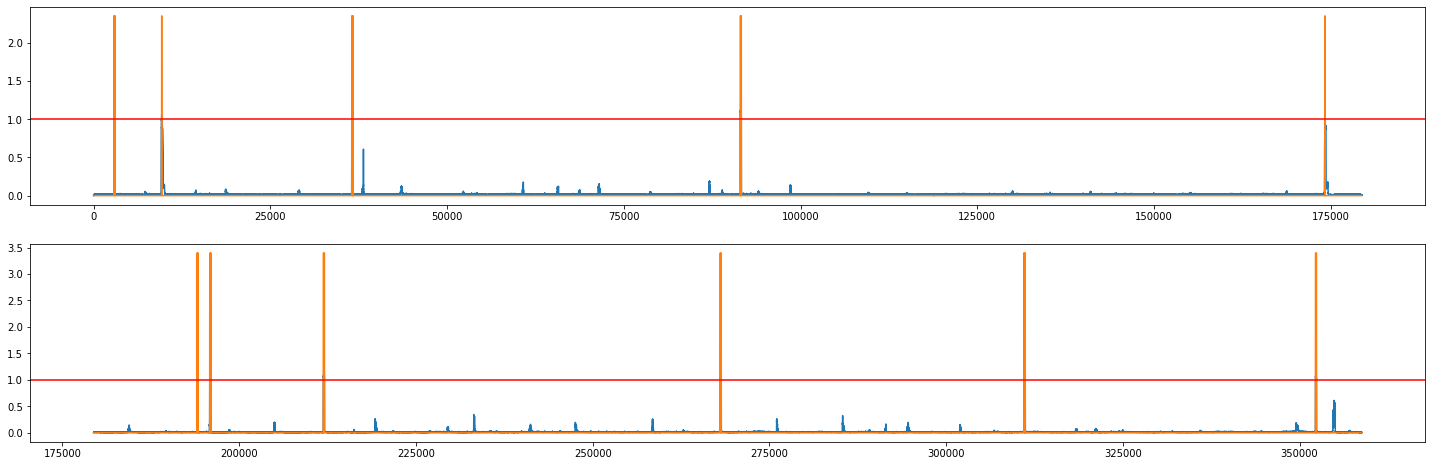

In [ ]:
threshold = 1
test_label_temp = put_labels(test_result, threshold)
check_graph(test_result, test_label_temp, piece = 2, THRESHOLD= threshold)

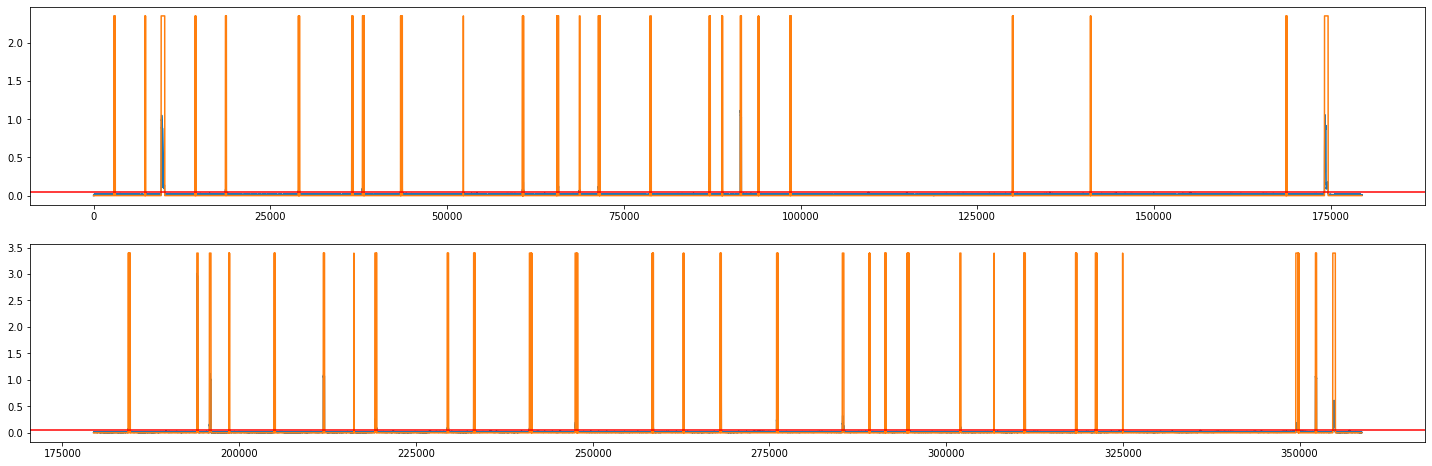

0.9185428836376822473135270965


In [ ]:
th = 0.045
TaPR = etapr.evaluate(anomalies=valid_label, predictions = put_labels(valid_result, th))
test_label = put_labels(test_result, th)
check_graph(test_result, test_label, piece = 2, THRESHOLD= th)
print(TaPR['f1'])

In [ ]:
submission = pd.read_csv(path_submission)
submission['attack'] = test_label
submission.to_csv(path+'submission_' + 'test6.csv',index = False)

0.38 - 0.9007696757	

0.4 - 0.9152108916	

0.42 - 0.9146625968

In [ ]:
# HAI_predict_3_8_epoch_7.h5
# HAI_predict_3_4_epoch_8.h5 - 0.045 / 0.04
# HAI_predict_3_8_epoch_12.h5 - 0.042 / 0.045(test6)